Hemos visto ya en la **Parte 1**, como analizar el potencial de una estrategia y si es factible o no continuar puliendola, vamos ahora a encontrar los mejores parametros para dicha estrategia

# Encontrando los mejores parametros para nuestra estrategia de cruces SMAs

In [1]:
pip install ta

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=ed77de08d92b10c3cdeb7cb83357deeb14a4991dddd12b59f797bf7ac7932a0f
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta


In [3]:
pip install yfinance --upgrade --no-cache-dir

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta.trend import SMAIndicator

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use('ggplot')

In [5]:
# Mostar solo los 3 decimales en Dataframes
pd.options.display.float_format = "{:,.3f}".format

In [6]:
asset = 'EURUSD=X'
start_date = '2010-01-01'
end_date = '2020-12-04'
data = yf.download(asset, interval = '1d', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [7]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,1.433,1.440,1.433,1.439,1.439,0
2010-01-04,1.431,1.445,1.426,1.442,1.442,0
2010-01-05,1.443,1.448,1.435,1.437,1.437,0
2010-01-06,1.437,1.443,1.429,1.440,1.440,0
2010-01-07,1.440,1.444,1.430,1.432,1.432,0
...,...,...,...,...,...,...
2020-11-30,1.197,1.200,1.194,1.197,1.197,0
2020-12-01,1.194,1.205,1.194,1.194,1.194,0
2020-12-02,1.207,1.211,1.204,1.207,1.207,0


# Empaquetamos nuestra Estrategia SMA dentro de una Funcion

In [15]:
def correr_estrategia(DF, SMAs):
  df = DF.copy()
  df['retornos'] = df['Adj Close'].pct_change()
  df['sma_short'] = SMAIndicator(df['Adj Close'], int(SMAs[0]), True).sma_indicator()
  df['sma_long'] = SMAIndicator(df['Adj Close'], int(SMAs[1]), True).sma_indicator()
  df['posicion'] = np.where(df['sma_short'] > df['sma_long'], 1, -1)
  df['estrategia'] = df['posicion'].shift(1) * df['retornos']
  df.dropna(inplace=True)

  # Devuelve el rendimiento absoluto de 'retornos' y 'estrategia'
  # calculando la ganancia o perdida de cada $1 invertido, usando: '.apply (np.exp)'
  # Ademas, al final, podemos llamar solo a los resultados de 'estrategia', llamando solo a la columna 'estrategia'
  return df[['retornos', 'estrategia']].sum().apply(np.exp) # ['estrategia']

La función ***correr_estrategia*** toma 2 parámetros:
- **DF**: dataframe con datos históricos.
- **SMA**: Este puede tomar **varios** parámetros a la vez, ya que más adelante en el código, estaremos usando ***int(SMAs[0])*** y ***int(SMAs[1])*** que, básicamente, convierte el único parámetro (SMA), en dos!, siendo el numero de intervalos o *rolling window* que usaremos en nuestros dos MMSs (SMAs) (short y long). Por lo cual, en el momento de llamar a la función, lo haremos así:
     - correr_estrategia(dataframe, (50, 200))
         - *50 y 200 corresponden a las SMA corta y larga (short y long)*


**NOTA**: *Esta forma de código podria ser un tanto confusa al inicio, pero es bueno saber que es posible hacerlo de esta manera. Una mejor forma de hacerlo sería declarar dos parámetros separados para la función*.

In [16]:
correr_estrategia(data, (22, 200))

retornos     0.883
estrategia   1.270
dtype: float64

In [17]:
correr_estrategia(data, (9, 80))

retornos     0.883
estrategia   0.845
dtype: float64

In [18]:
correr_estrategia(data, (50, 100))

retornos     0.883
estrategia   1.344
dtype: float64

In [19]:
correr_estrategia(data, (50, 254))

retornos     0.883
estrategia   1.464
dtype: float64

# Encontrando la Mejor Combinacion de SMAs utilizando ***Fuerza Bruta***

Para esto, usaremos el método ***brute()*** del paquete: ***scipy***

El método *.brute()* encuentra el valor mínimo de una función (NO el máximo), pero como estamos tratando de encontrar el valor *máximo* del rendimiento, tenemos que aplicar un pequeño *truco* a nuestra función para que podamos hacer que el método *.brute()* funcione para nosotros. Simplemente agregamos el signo negativo (-) a el resultado de nuestra función, esto permitirá que el método *.brute()* funcione correctamente.

Además, recordemos que el método encontrara el valor mínimo UNICO, por lo que nuestra función tiene que devolver un valor negativo de SOLO UNA columna, en este caso: la columna **'estrategia'**

In [21]:
from scipy.optimize import brute

In [22]:
def correr_estrategia(SMAs):
  df = data.copy()
  df['retornos'] = df['Adj Close'].pct_change()
  df['sma_short'] = SMAIndicator(df['Adj Close'], int(SMAs[0]), True).sma_indicator()
  df['sma_long'] = SMAIndicator(df['Adj Close'], int(SMAs[1]), True).sma_indicator()
  df['posicion'] = np.where(df['sma_short'] > df['sma_long'], 1, -1)
  df['estrategia'] = df['posicion'].shift(1) * df['retornos']
  df.dropna(inplace=True)

  # Se agrego el signo negativo (-), para que el metodo 'brute' pueda funcionar en nuestra funcion
  return -df[['retornos', 'estrategia']].sum().apply(np.exp)['estrategia']

Ahora, para que el método funcione, tenemos que agregar los siguientes parámetros:

- La función.
- El rango para la SMA corta (short) y su ventana de cambio. en nuestro caso, usaremos el rango entre 10 y 50 SMA con ventana de 1.
- El rango para la SMA larga (long) y su ventana de cambio. en nuestro caso, usaremos el rango entre 100 y 252 SMA con ventana de 1.

Entonces, cuando el método esté funcionando, primero se buscará la combinación de 10 y 100, luego 11 y 100, luego 12 y 100 y así sucesivamente.

In [23]:
brute(correr_estrategia, ((10, 50, 1), (100, 252, 1)), finish=None)

array([ 48., 134.])

***'finish=None'*** hace que el método 'brute' use solo los valores dentro de la cuadrícula o rango*

Después de ejecutar el método ***brute()***, descubrimos que la mejor combinación para nuestros SMA es:
- Una SMA corta de **47**, y
- Una SMA larga de **136**

***NOTA***: *Recordemos que el método tardará más si hay una gran cantidad de combinaciones, pero para nuestros requerimientos actuales, funciona bien.*

Ahora ejecutamos de nuevo la función inicial con los parámetros *óptimos* encontrados por el método *.brute()*.

**Recordemos que ahora la funcion devolverá un valor NEGATIVO (debido al método brute())** así que agregaremos otro signo negativo (-) al comienzo de la función, por lo que devolverá un valor positivo (+), asi evitando cualquier confusion.

In [26]:
-correr_estrategia((47,136))

1.725252993138822

Podemos ejecutar nuevamente la **Parte 1** de esta Estrategia *(Estgia.01 - [Vect] Cruce de SMAs [Parte 1])*, pero esta vez, usando los valores optimizados para nuestras SMA, entonces podremos ver los gráficos y los resultados con los nuevos valores.

[*********************100%***********************]  1 of 1 completed


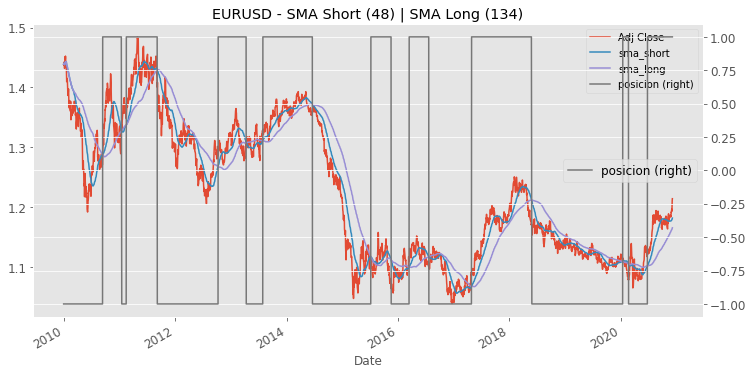

In [27]:
asset = 'EURUSD=X'
start_date = '2010-01-01'
end_date = '2020-12-04'
data = yf.download(asset, interval='1d', start = start_date, end = end_date)

# Usando los valores optimizados en las SMAs
data['sma_short'] = SMAIndicator(data['Adj Close'], 47, True).sma_indicator()
data['sma_long'] = SMAIndicator(data['Adj Close'], 136, True).sma_indicator()

data['posicion'] = np.where(data['sma_short'] > data['sma_long'], 1, -1)

data[['Adj Close', 'sma_short', 'sma_long', 'posicion']].plot(figsize = (12,6),
                                                              title = 'EURUSD - SMA Short (48) | SMA Long (134)',
                                                              fontsize = 12,
                                                              secondary_y = 'posicion')
plt.legend(fontsize = 12)
plt.show()

# Retornos de la Estrategia y del Instrumento

In [28]:
data['retornos_del_instrumento'] = data['Adj Close'].pct_change()
data['estrategia_retorno'] = data['posicion'].shift(1) * data['retornos_del_instrumento']

data.dropna(inplace = True)

# Retornos Acumulativos

In [29]:
data['retornos_del_instrumento_acum'] = data['retornos_del_instrumento'].cumsum().apply(np.exp)
data['estrategia_retorno_acum'] = data['estrategia_retorno'].cumsum().apply(np.exp)

# Ploteando los Retornos Acumulativos

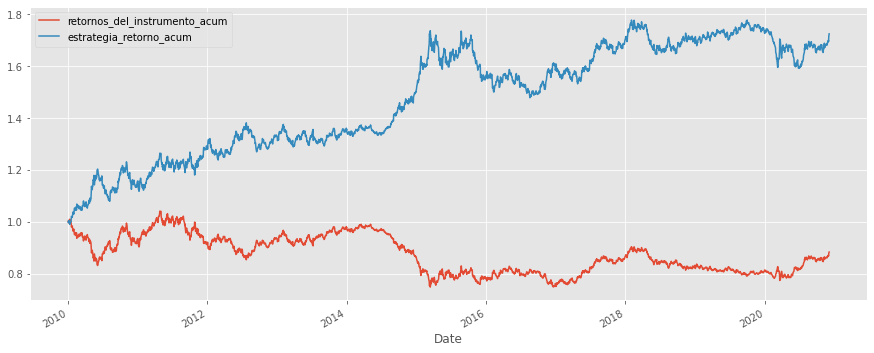

In [32]:
data[['retornos_del_instrumento_acum', 'estrategia_retorno_acum']].plot(figsize=(15,6))
plt.show()

Podemos ver que ahora el grafico luce mas estable que cuando coloacamos los valores de las SMAs aleatoriamente [*Parte 1*] , lo q significa que la estrategia y las *ganancias* son mas estables tambien.

In [33]:
# Con cuanto supera nuestra estrategia el benchmark (Buy and Hold)
pct_superado = data['estrategia_retorno_acum'].iloc[-1] - data['retornos_del_instrumento_acum'].iloc[-1]
pct_superado

0.8423058379352588

Podemos ver que nuestra estrategia ha superado al benchmark por un **95%.**

# Empaquetando los Medidores de Efectividad en una Funcion
CAGR, Volatilidad Anual, Sharpe Ratio, Sortino Ratio, MDD, Calmar Ratio

In [37]:
def Medidores_de_Riesgo(DF, riskfree_rate=0.022):
  df = DF.copy()

  # Prepara los datos que son necesarios para el uso del metodo 'Medidores_de_Riesgo'
  df['instrumento_retornos']   = df['Close'].pct_change()
  df['estrategia_retornos'] = df['posicion'].shift(1) * df['instrumento_retornos']
  df.dropna(inplace=True)
  df['estrategia_retornos_acum'] = df['estrategia_retornos'].cumsum().apply(np.exp)

  # CAGR --------------------------------------------------------------------/
  numero_de_anios = len(df)/252 
  CAGR = (df['estrategia_retornos_acum'][-1])**(1/numero_de_anios) -1 
  
  # Volatilidad Anual -------------------------------------------------------/
  vol = df['instrumento_retornos'].std()* np.sqrt(252) 

  # Sharpe Ratio ------------------------------------------------------------/
  sharpe_ratio = (CAGR - riskfree_rate) / vol
  
  # Sortino Ratio -----------------------------------------------------------/
  neg_vol = df[df['instrumento_retornos'] < 0]['instrumento_retornos'].std() * np.sqrt(252) 
  sortino_ratio = (CAGR - riskfree_rate) / neg_vol
  
  # MDD ---------------------------------------------------------------------/
  df['max_ret_acum'] = df['estrategia_retornos_acum'].cummax()
  df['drawdown'] = df['max_ret_acum'] - df['estrategia_retornos_acum']
  df['drawdown_pct'] = df['drawdown'] / df['max_ret_acum']
  mdd = df['drawdown_pct'].max()
  
  # Calmar Ratio ------------------------------------------------------------/
  calmar = CAGR / mdd

  # Imprime los Valores con sus Respectivos Textos
  print("RENDIMIENTO DE LA ESTRATEGIA")
  print("-" * 100)
  print("CAGR (Rendimiento Anual): " + str(round((CAGR*100), 2)) + "%")
  print("Volatilidad Anual: " + str(round((vol*100), 2)) + "%")
  print("Maximum Drawdown(MDD): " + str(round((mdd*100), 2)) + "%")
  print("Sharpe Ratio: " + str(round(sharpe_ratio, 2)))
  print("Sortino Ratio: " + str(round(sortino_ratio, 2)))
  print("Calmar Ratio: " + str(round(calmar, 2)))

In [38]:
Medidores_de_Riesgo(data)

RENDIMIENTO DE LA ESTRATEGIA
----------------------------------------------------------------------------------------------------
CAGR (Rendimiento Anual): 4.97%
Volatilidad Anual: 8.94%
Maximum Drawdown(MDD): 14.89%
Sharpe Ratio: 0.31
Sortino Ratio: 0.45
Calmar Ratio: 0.33


# Conclusion

Podemos ver que si bien hemos visto *mejores* resultados, tengamos en cuenta algunas limitaciones de este tipo de backtesting. Cuando una estrategia **NO ESTÁ** basada en datos históricos o **NO ESTÁ** optimizada para manejar datos históricos, entonces el tipo de backtesting es apropiado.

En nuestro caso, **hemos ajustado y optimizado la estrategia a los datos históricos** Entonces nuestro Algoritmo se *ajusta* a los datos historicos. Así que no hay garantía de que la estrategia testada con este metodo funcione en el futuro!

Por lo tanto, si la estrategia es basada en datos historicos, la solución es probarla con datos fuera de la muestra (out-of-sample data), siendo que parte de los datos históricos no se usan para la optimización del backtest. O mejor aún, usar datos frescos o nuevos, esto se lo llama ***forward testing***

A continuacion estaremos empaquetando nuestra estrategia en una ***clase***, que nos permitira testar varias estrategias, maximizando de gran manera el codigo que ya tenemos escrito, asi *reusando* varias partes del mismo, ahorrandonos tiempo y recursos.